In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df1 = pd.read_csv('train.csv')

X = df1.drop('SalePrice', axis=1)
y = df1['SalePrice']

# Step 1: Drop columns with too many missing values
min_rows = df1.shape[0] / 2
X = X.loc[:,df1.isna().sum() < min_rows]

numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Step 2: Create pipeline for handling missing data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Step 3: Combine pipelines as preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Step 4: Transform data (We transformed before fitting because some model splits data into multiple sub-samples during which encoder didn't worked well even after stratified K-fold.)
X_new = preprocessor.fit_transform(X)
all_features = numeric_features.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
X_new = pd.DataFrame(X_new, columns = all_features )

# Replace rare categories with 'Other'
threshold = 10
for col in categorical_features:
    value_counts = X[col].value_counts()
    rare_values = value_counts[value_counts < threshold].index
    X[col] = X[col].replace(rare_values, 'Other')


In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
import warnings

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(max_iter=50000, alpha=0.1),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor()
}

skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: Loop through models and evaluate performance
results = {}
for name, model in models.items():    
    # Evaluate using cross-validation
    scores = cross_val_score(model, X_new, y, cv=skf, scoring='r2')
    
    # Store the mean score
    results[name] = scores.mean()

# Print the results
print("Model Performance (R² Score):")

for model, score in results.items():
    print(f"{model}: {score:.4f}")


Model Performance (R² Score):
Linear Regression: 0.6744
Ridge Regression: 0.7907
Lasso Regression: 0.6788
Random Forest Regressor: 0.8371
Gradient Boosting Regressor: 0.8479
Decision Tree Regressor: 0.6854
Support Vector Regressor: -0.0532
K-Nearest Neighbors Regressor: 0.7559


In [4]:
from sklearn.model_selection import GridSearchCV 

model = GradientBoostingRegressor()
param_grid = {
    'model__n_estimators':[150,200,250],
    'model__learning_rate':[0.01,0.1],
    'model__max_depth':[3,5,7],
    'model__subsample':[0.7,0.8,0.9]
}
pipeline = Pipeline(steps=[('model', model)])

grid = GridSearchCV(pipeline, param_grid, cv=2, scoring='r2')
grid.fit(X_new,y)

print(f"Best Params: {grid.best_params_} with score {grid.best_score_}")


Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 150, 'model__subsample': 0.7} with score 0.8743673656140265


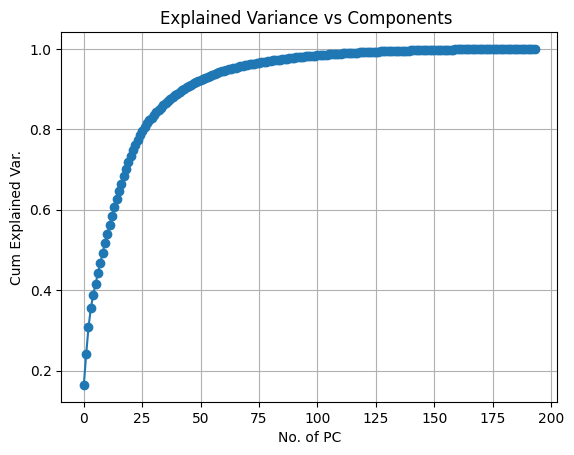

In [6]:
from sklearn.metrics import r2_score 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

y_new = np.log1p(y) # From EDA we performed, we found that the target variable is right skewed

X_new2 = X.drop('GarageArea',axis=1) # High correlation with 'GarageCars'

numeric_features_new = X_new2.select_dtypes(include=['int64','float64']).columns
categorical_features_new = X_new2.select_dtypes(include=['object']).columns

preprocessor2 = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features_new),
    ('cat', categorical_pipeline, categorical_features_new)
])

# Preprocessing
X_new2 = preprocessor2.fit_transform(X_new2)
all_features = numeric_features_new.tolist() + preprocessor2.named_transformers_['cat'].get_feature_names_out().tolist()
X_new2 = pd.DataFrame(X_new2, columns = all_features )

# PCA visualization
pca = PCA()
X_pca = pca.fit_transform(X_new2)
explained_variance_ratio = pca.explained_variance_ratio_
cum_ex_var = np.cumsum(explained_variance_ratio)

plt.plot(cum_ex_var, marker='o')
plt.xlabel("No. of PC")
plt.ylabel("Cum Explained Var.")
plt.title("Explained Variance vs Components ")
plt.grid()
plt.show()

In [13]:
# Full pipeline for model training with pca
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_new)

final_preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features_new),
    ('cat', categorical_pipeline, categorical_features_new)
])

final_pipeline = Pipeline(steps=[
    ('preprocessing',final_preprocessor),
    ('pca', PCA(n_components=100)), # 100 PC provide enough info while others are probably noise
    ('model', GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=150, subsample=0.7)) # parameter from above fine tuning
])

final_pipeline.fit(X_train,y_train)
y_pred = final_pipeline.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"Score with 100 PC: {score}")

Score with 100 PC: 0.8923356870684811


In [17]:
# Prediction on unseen data
data = pd.read_csv('test.csv')
test = pd.DataFrame(data)

y_pred_log = final_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_pred

array([121263.90081362, 207546.0872474 , 268690.64368051, 114872.06733738,
       188103.19957217, 199289.21195753, 333003.41856236, 163647.86681061,
       224867.01658969, 207788.32444899, 104428.34663886, 154092.82182662,
       120590.30435532, 125974.57678932, 140790.00786508, 150823.63913768,
       105607.8767707 , 194902.67583843, 148196.64704202, 312235.67435063,
       175523.08760045, 142981.51149602, 122045.16927572, 239443.18209827,
        93252.361172  ,  92840.38157773, 162475.79256116, 146091.87958473,
       458624.45036966, 228984.63747528, 140535.83308212, 192974.02538179,
       198315.94994957,  59950.12694795, 220333.75293754,  88741.1188343 ,
       159616.03994141,  95875.0412703 , 115332.25886853, 117328.67741677,
       124948.71483884, 234340.79687638, 153784.88991186, 112648.6729023 ,
        88374.62645002, 199956.58717914, 203818.80707389, 142922.93698213,
        86156.34968864,  90069.18462584, 168451.99678192, 370724.99837658,
       142134.54852819, 1

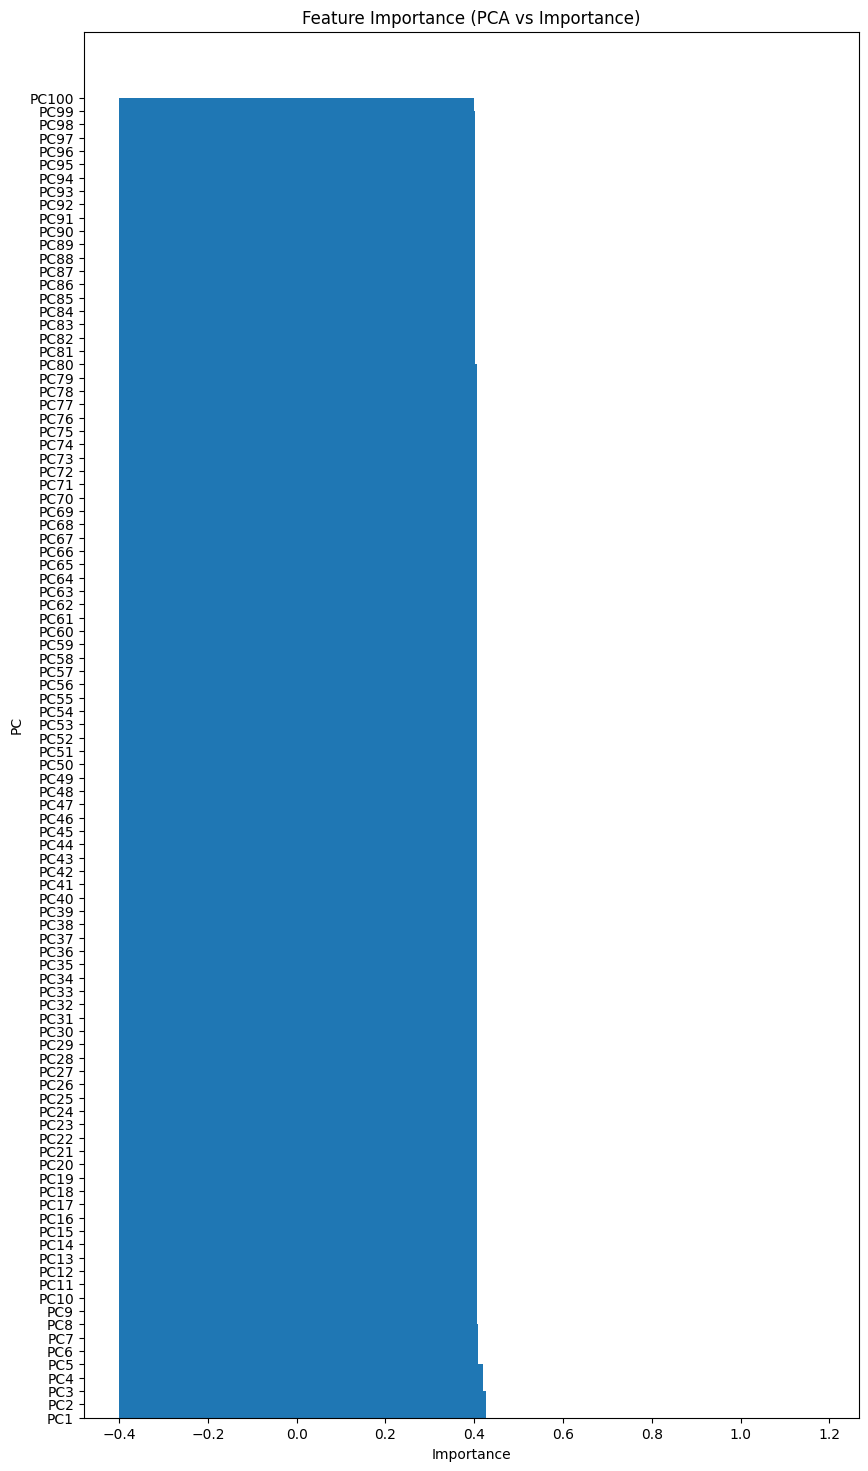

In [18]:
# We selected no. of components based on information(explained variance) they provided
# Hence, they should contain almost equal value for feature importance
all_features = ['PC'+ str(i) for i in range(1,101)]

importance = pd.DataFrame({
    'features': all_features,
    'importances': final_pipeline.named_steps['model'].feature_importances_
})

plt.figure(figsize=(10,18))
plt.bar(importance['importances'], importance['features'])
plt.xlabel("Importance")
plt.ylabel("PC")
plt.title("Feature Importance (PCA vs Importance)")
plt.show()

In [19]:
from joblib import dump
dump(final_pipeline,'model.pkl')

['model.pkl']